Purpose: Approximately integrate nitrous oxide emissions starting from 1750, and compute atmospheric concentration

Clear all variables and reset the working directory and import necessary libraries

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import curve_fit
import csv

import mpmath
from sympy import integrate
from sympy import Symbol
from sympy import evalf
from scipy.integrate import quad
import scipy
import math
os.chdir('C:\\Users\\cd7\\Desktop\\Heat17N2O')

Read three input files separately and assign the year values and methane concentration data

In [2]:
df1 = pd.read_excel('heat18parameters13jan.xlsx')
df1.to_csv('heat18parameters13jan.csv',header=False,index=False)
df1 = pd.read_csv('heat18parameters13jan.csv')

df2 = pd.read_excel('heat17-n2o-1-2017dec16.xlsx') # results of excel sheet from code of radiative forcing
df2.to_csv('heat17-n2o-1-2017dec16.csv',header=False,index=False)
df3 = pd.read_csv('heat17-n2o-1-2017dec16.csv')
df3.drop(df3.index[[-1]],inplace=True)
print (df3)

     Julian                 ppb
0         1   263.1505461767626
1         2   263.0509433962264
2         3   263.0509433962264
3         4   262.9513406156901
4         5   262.9513406156901
5         6  262.85173783515387
6         7  262.75213505461767
7         8  262.75213505461767
8         9  262.65253227408135
9        10  262.65253227408135
10       11  262.55292949354515
11       12  262.55292949354515
12       13   262.4533267130089
13       14   262.4533267130089
14       15  262.35372393247263
15       16  262.35372393247263
16       17  262.35372393247263
17       18  262.25412115193643
18       19  262.25412115193643
19       20   262.1545183714002
20       21   262.1545183714002
21       22   262.1545183714002
22       23   262.1545183714002
23       24   262.0549155908639
24       25   262.0549155908639
25       26   262.0549155908639
26       27   262.0549155908639
27       28   262.0549155908639
28       29   262.0549155908639
29       30   262.0549155908639
...     

Assemble and Plot Data

In [3]:
b11 = df1.iloc[10,0:4]
# print (b11)
ndrop = 1749
df4 = df3.iloc[ndrop:]
df4.index = np.arange(0, len(df4))
print (df4)

    Julian                 ppb
0     1750  270.12274081429985
1     1751   270.4215491559086
2     1752  270.72035749751734
3     1753   271.1187686196623
4     1754  271.41757696127104
5     1755   271.7163853028798
6     1756  272.01519364448853
7     1757  272.31400198609725
8     1758  272.61281032770603
9     1759   272.8120158887785
10    1760    273.011221449851
11    1761   273.1108242303872
12    1762   273.2104270109235
13    1763   273.2104270109235
14    1764   273.1108242303872
15    1765   273.1108242303872
16    1766    273.011221449851
17    1767  272.91161866931475
18    1768   272.8120158887785
19    1769   272.7124131082423
20    1770  272.61281032770603
21    1771  272.51320754716977
22    1772   272.4136047666335
23    1773  272.21439920556105
24    1774   272.1147964250248
25    1775  272.01519364448853
26    1776    271.815988083416
27    1777   271.7163853028798
28    1778  271.61678252234356
29    1779  271.41757696127104
..     ...                 ...
238   19

Rename the output files

In [4]:
out1 = 'historical'
out2 = 'n2o'
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] # abbreviations for months to insert in output file name
date = datetime.date.today().strftime("%Y-%m-%d")
date_split = date.split('-') # split the date string we create by symbol "-"
yrs = str(int(date_split[0])-2000) # real years minus 2000
seq = [out1, yrs, out2,months[int(date_split[1])-1],date_split[2]]
seperator = ','
filename = seperator.join(seq).replace(',', '')

Solve the <N2O> balance equation using fitemit

$\frac{d<N_2O>}{dt} = f(t)-\frac{<N_2O>}{b_0}$ with $f=\frac{b_1}{1+e^{(-(t-b_2)/b_3)}} $ has the long term limit solution $<N_2O>->b_0*b_1$.<br>
So let $y=\frac{<CH_4>}{b_0*b_1}$ evolve from a small value of y0 at t=t0=1750 and always be less than 1 at any finitely larger time.
Then $b_0*b_1*\frac{dy}{dt}= f-b1*y$ and $b0*\frac{dy}{dt}=\frac{f}{b_1}-y$.
Let $x =\frac{t-b_2}{b_3}$, so dt=b_3*dx and $u=\frac{1}{(1+e^{(-x)})} $be a unit logistic function and $\delta=\frac{b_3}{b_0}$. Then $\frac{dy}{dx}=u-\delta*y$, where here

In [5]:
life = 128.012  #(* from heat17n2oemissions16dec.nb *)
n2o0 = 267.291  #(* from heat17<n2o>dec16.nb *)
# print (type(n2o0))
# delta = float(delta)
# b11[0] = float(b11[0])
# b11[1] = float(b11[1])
# b11[2] = float(b11[2])
# b11[3] = float(b11[3])
delta = b11[2]/b11[3]
print (delta)

def x(t):
    y = (t - b11[1])/b11[2]
    return y


def u(t):
    y = 1/(1 + np.exp(-x(t)))
    return y
# mpmath.polylog = np.frompyfunc(mpmath.polylog,2,-np.exp(x(t)))
def n2ofit(t):
    y = n2o0 + b11[0]*b11[2]*(np.log(1+np.exp(x(t)))+delta*mpmath.polylog(2,-np.exp(x(t)))-delta**2*mpmath.polylog(3,-np.exp(x(t))))
    return y
n2ofit = np.vectorize(n2ofit)

0.3149532856294722


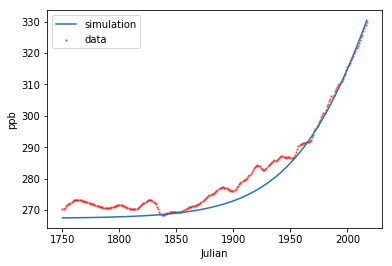

In [6]:
t0 = ndrop + 1
tmax = 2017
t = range(t0,tmax+1)

df4 = df4.astype(float)
df4.plot.scatter(x='Julian',y='ppb',s=2,color = 'r', alpha = 0.5,label ='data',marker='o')
y = n2ofit(t)
plt.plot(t,y,label="simulation")
plt.legend(loc='best')
plt.savefig('n2o010.eps',dpi=1000)
plt.savefig('n2o010.pdf',dpi=1000)
plt.show()

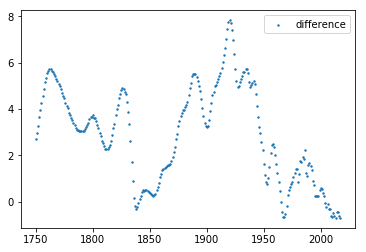

In [7]:
yrs = t
n2odata = df4['ppb']
def diff(t):
    y = n2odata - n2ofit(t)
    return y
y1 = diff(yrs)
plt.scatter(t,y1,s=2,label="difference")
plt.legend(loc='best')
plt.savefig('n2o011.eps',dpi=1000)
plt.savefig('n2o011.pdf',dpi=1000)
mean = np.mean(y1)

yrs = list(yrs)
y1 = y1.tolist()
y1 = list(map(float, y1))

least square fit

In [8]:
def err(yrs,b1,b2,b3):
     y = b1*(1-1/(1 + np.exp(-(yrs-b2)/b3)))
     return y
param_bounds=([0,1900,0],[10,2000,10])
popt, pcov = curve_fit(err,yrs,y1, bounds=param_bounds)
print (popt)

[   3.67156531 1955.39562285    4.68890406]


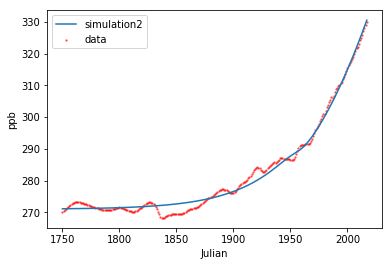

In [9]:
# x_new = list(range(1750,2301)) # plot from year 1750 to 2300
# x = np.array(x_new)
def refit(t):
    y = n2ofit(t) + err(t, *popt)
    return y
# t = range(t0,tmax+1)
# y3 = refit(t)
# plt.plot(t,y3,label="simulation2")
df4 = df4.astype(float)
df4.plot.scatter(x='Julian',y='ppb',s=2,color = 'r', alpha = 0.5,label ='data',marker='o')
plt.plot(t,refit(t),label="simulation2")
plt.legend(loc='best')
plt.savefig('n2o012.eps',dpi=1000)
plt.savefig('n2o012.pdf',dpi=1000)
plt.show()

In [10]:
yrsuse = df4['Julian']
# n2ofitout = eval('refit(yrsuse)')
n2ofitout = refit(yrsuse)
print (n2ofitout)
# delta**3

0      271.103543611207
1      271.107080272026
2      271.110705559376
3      271.114421689299
4      271.118230933007
5      271.122135618229
6      271.126138130616
7       271.13024091516
8      271.134446477662
9      271.138757386222
10     271.143176272778
11     271.147705834675
12     271.152348836268
13     271.157108110574
14     271.161986560953
15     271.166987162839
16     271.172112965503
17     271.177367093865
18     271.182752750346
19     271.188273216766
20     271.193931856285
21     271.199732115391
22     271.205677525938
23     271.211771707229
24     271.218018368146
25     271.224421309338
26     271.230984425454
27     271.237711707429
28      271.24460724483
29     271.251675228247
             ...       
238    305.581450861058
239    306.304739314702
240    307.037951638672
241    307.781071899885
242    308.534085232114
243     309.29697690479
244    310.069731566821
245    310.852332633742
246    311.644761792321
247    312.446998601497
248    313.25902

Compare expansion through $\delta^2$ to exact integration, showing the need for recalibration of the exact result if to be used for extrapolation.

In [11]:
tmin = 1750
tmax = 2017
def xn2o(t):
    y = (t - b11[1])/b11[2]
    return y
xn2o0 = xn2o(tmin)
print (xn2o0)

print (delta)

def f(x):
    return np.exp(delta*x)/(1 + np.exp(-x))
# print (f(x))
i,err = quad(f,-np.inf,xn2o0)

# i1,err1 = quad(f,-np.inf,x)
print (i)

x = sp.Symbol('x')
# y7 = quad(f)
# y7 = sp.integrate(np.exp(delta*x)/(1 + np.exp(-x)),x)
y8 = sp.integrate(sp.exp(delta*x)/(1 + sp.exp(-x)),x)
print (y8)

# def n2oexact(t):
# y9 = sp.integrate(math.exp(delta*x)/(1 + math.exp(-x)),x)

# fup = integrate(np.exp(delta*xn)/(1 + np.exp(-xn)), xn)
# def fup(x,0):
#     y = sp.integrate(np.exp(delta*x)/(1 + np.exp(-x)), x)
# #     y = sp.integrate(exp(delta*xn)/(1 + exp(-xn)), xn)
#     return y
# y8 = sp.integrate(np.exp(delta*x)/(1 + np.exp(-x)), x)
# y8 = sp.integrate(sp.exp(delta*x)/(1 + sp.exp(-x)), x)
# # y8 = sp.integrate(sp.exp(delta*x)/(1 + sp.exp(-x)), x).evalf(xn2o0)
# sp.integrate(sp.exp(delta*x)/(1 + sp.exp(-x)), x)
# print (np.exp(1.31495328562947*-6.28358)/(np.exp(-6.28358) + 1))
# print (y8)
# fup0 = fup(xn2o0,0)
# fup0 = evalf('y8(xn2o0)')
# fup0 = y8(xn2o0)
# fup = sp.integrate(exp(delta*xn)/(1 + exp(-xn)), xn)
# fup = sp.integrate(math.exp(delta*xn)/(1 + math.exp(-xn)), xn)

-6.283576980886852
0.3149532856294722
0.0001959853084408696


C:\Users\cd7\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


Integral(exp(1.31495328562947*x)/(exp(x) + 1), x)
